In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import keras_tuner as kt # used for hyperparameter tuning

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Printing first 5 records of the dataset
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dealing with Missing Values

### For Numerical Features

In [3]:
# to check for which column has null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

We can see that the dataset is freshed and contains no null values.\
Still sometimes a column may contain empty values (as spaces or NaNs). So we can check those and if any deal with them.
TotalCharge column as such empty string and that is why it is shown as object type rather than float64. So we can force TotalCharges to be converted to numeric data and then etting errors='coerce', which will convert any non-numeric entries to NaN.

In [4]:
# Convert 'TotalCharges' to numeric, coercing any errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


So we can see there is 11 null values for TotalCharges column. Here we deal them by applying KNN Imputation.

In [5]:
# Select columns with numeric data types only
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Select columns with categorical data types without target column Churn
cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop("Churn").tolist()

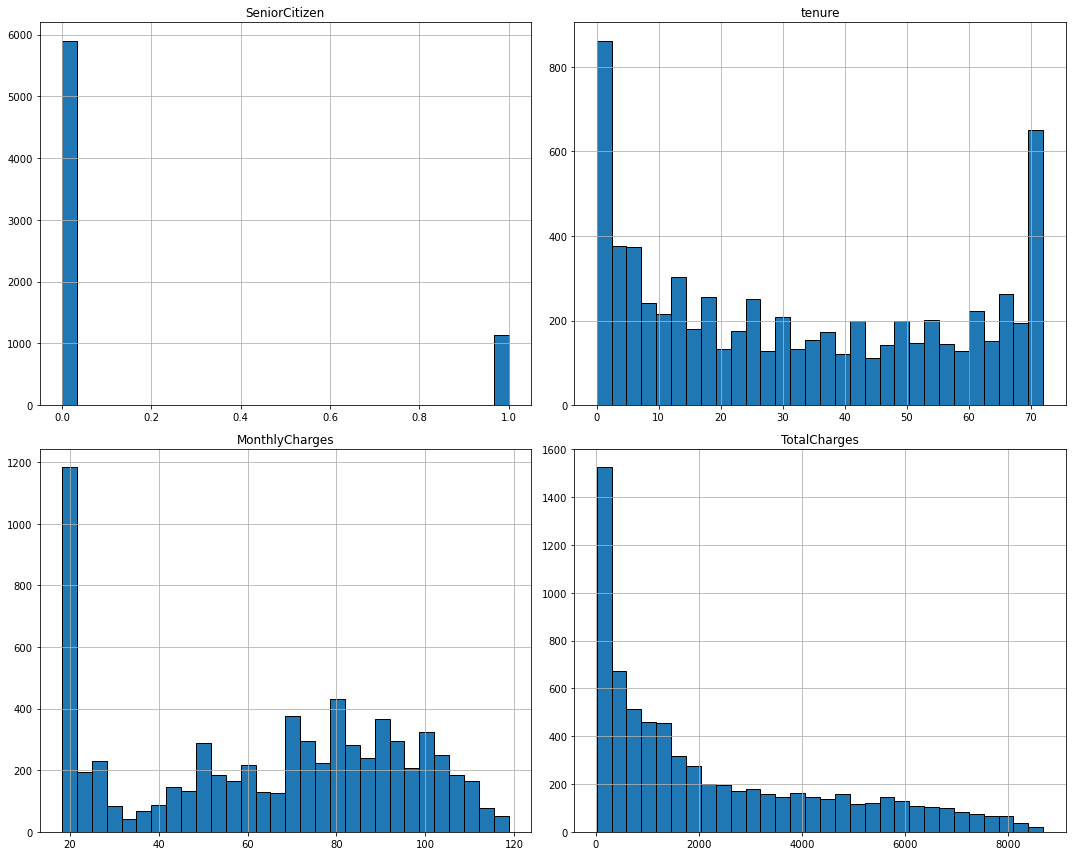

In [6]:
# plot histograms for numerical features
df[num_cols].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

We can see above histogram that SeniorCitizen has only two values. Therefore, we will leave this feature unchanged in the dataset. It will be treated similarly to other categorical or binary indicator features. Moreover, other features are skewed. So we can perform transformation according to skewness.

In [7]:
# we remove "SeniorCitizen" column from numerical features
num_cols = [n for n in num_cols if n != "SeniorCitizen"]

### calculate skewness for the numerical features

In [8]:
# check for skewed data
# Calculate skewness for each numerical column using skew and kurtosis
skewness = df[num_cols].apply(lambda x: skew(x.dropna()))

kurt = df[num_cols].apply(lambda x: kurtosis(x.dropna()))

# Combine skewness and kurtosis in a DataFrame
num_cols_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})
print(num_cols_df.sort_values(by = ['Skewness', 'Kurtosis'], ascending=[True, True]))

                Skewness  Kurtosis
MonthlyCharges -0.220477 -1.257219
tenure          0.239489 -1.387239
TotalCharges    0.961437 -0.232487


1. MonthlyCharges\
Skewness: -0.220 (slightly negatively skewed)\
Kurtosis: -1.257 (platykurtic, meaning it has a flat distribution compared to a normal distribution)\
Interpretation: The distribution of MonthlyCharges is close to symmetric (skewness is near zero) and has lower peak (flatness) than a normal distribution.

2. tenure\
Skewness: 0.239 (slightly positively skewed)\
Kurtosis: -1.387 (also platykurtic, or flatter than a normal distribution)\
Interpretation: Like MonthlyCharges, tenure has a near-normal distribution. It has a very slight positive skew and is also somewhat flat, with fewer extreme values.

Action: For both the features, no transformation is needed here, as the skewness is minimal.

3. TotalCharges\
Skewness: 0.961 (moderate positive skew)\
Kurtosis: -0.232 (slightly platykurtic but close to normal)\
Interpretation: TotalCharges has a moderate positive skew, meaning the distribution is pulled towards higher values. This skewness could potentially affect models sensitive to outliers or skewed data.\
\
Action: Since there’s moderate positive skewness, we can apply a transformation to normalize it. A logarithmic transformation (log1p) can help reduce the skew.

### Check for outliers

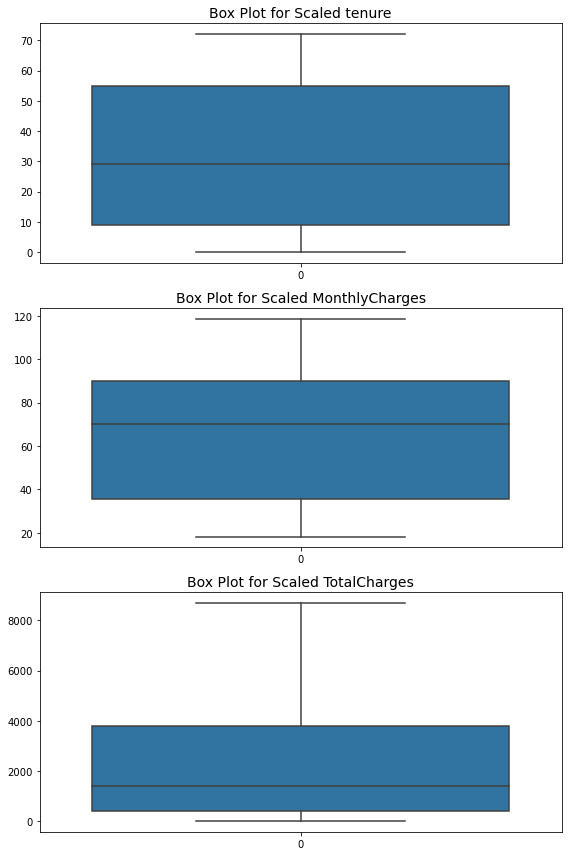

In [9]:
# Visualization by Boxplot
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 12))

# Loop through each numerical column and plot both histogram and boxplot
# Plot each feature in a separate subplot
for i, cols in enumerate(num_cols):
    sns.boxplot(data=df[cols], ax=axes[i])
    axes[i].set_title(f'Box Plot for Scaled {cols}', fontsize=14)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

We can see that there is no outliers for the numerical features. SO we don't need to deal with outliers explicitely.

### Perform Pipeline

We perform here a pipeline for dealing with missing value of the numerical features, transformation and scalling.

In [10]:
# Define feature groups
num_col_skewed = ["TotalCharges"]
num_col_no_skewed = [col for col in num_cols if col not in num_col_skewed]

print(num_col_skewed, num_col_no_skewed)

['TotalCharges'] ['tenure', 'MonthlyCharges']


In [11]:
# Transformer for unskewed numerical features, we perform here only scaling as these features contains no nul values
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Scaling
])

# Transformer for skewed numerical features
num_transformer_skewed = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=False)),  # Apply log transformation
    ('imputer', KNNImputer(n_neighbors=3)),                            # Apply KNN imputation
    ('scaler', StandardScaler())                                       # Scaling
])

## Categorical Features Visualization

In [12]:
df[cat_cols].nunique() == len(df)

customerID           True
gender              False
Partner             False
Dependents          False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
dtype: bool

We can see that for customerID column all the values are unique. So, it is best to drop the customerID column.Because, this feature functions purely as an identifier and does not hold any intrinsic predictive value about the target variable.\
But later in future work for Feature Engineering if it is needed we will consider it.

In [13]:
# we drop the column customerID
df.drop(columns = ["customerID"], inplace=True)
cat_cols = [c for c in cat_cols if c != "customerID"]

We visualize here the target feature

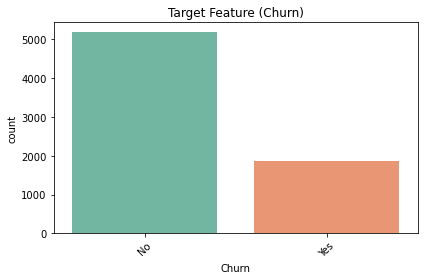

In [14]:
sns.countplot(data=df, x="Churn", palette='Set2')
plt.title("Target Feature (Churn)") # print feature name along with the percantage of missing values in the feature
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We can easily notice that in the target feature non-churners constitute the majority class. As a result, dataset is imbalance. Later, we will deal with that.

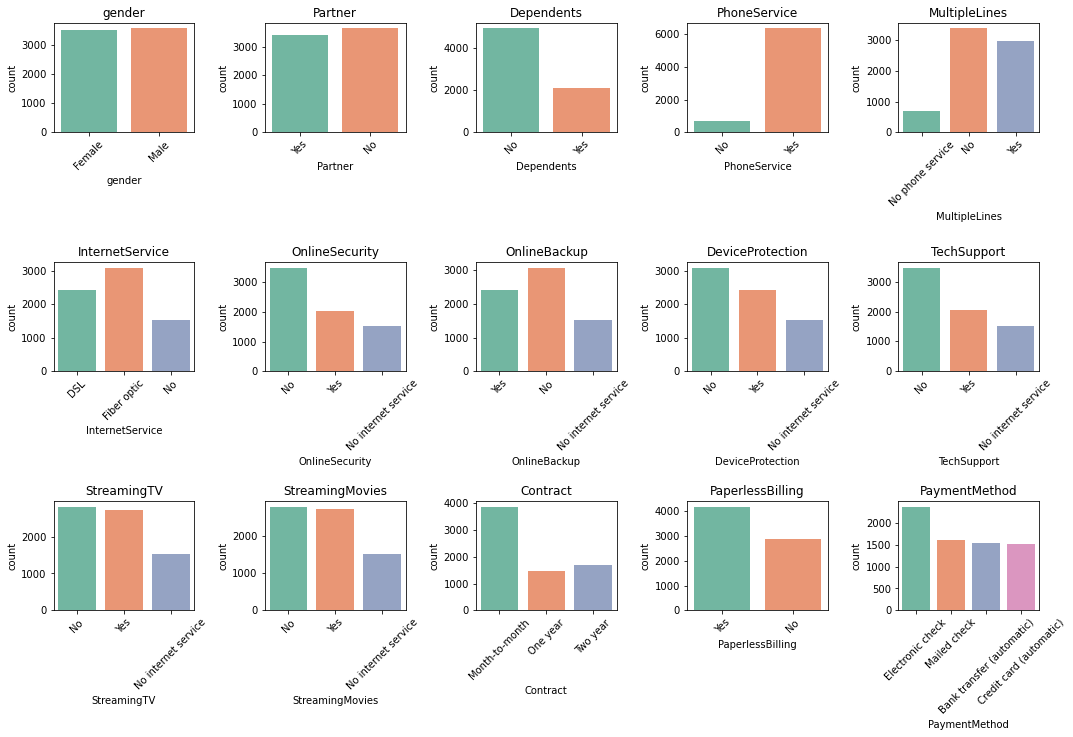

In [15]:
# Bar Plot, the distribution of a categorical variable
# Shows the frequency of each category in a single categorical feature.

plt.figure(figsize=(15, 12))
for i, column in enumerate(cat_cols, 1):
    plt.subplot(4, 5, i)  # Adjust subplot layout as per number of features
    sns.countplot(data=df, x=column, palette='Set2')
    plt.title(column) # print feature name along with the percantage of missing values in the feature
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

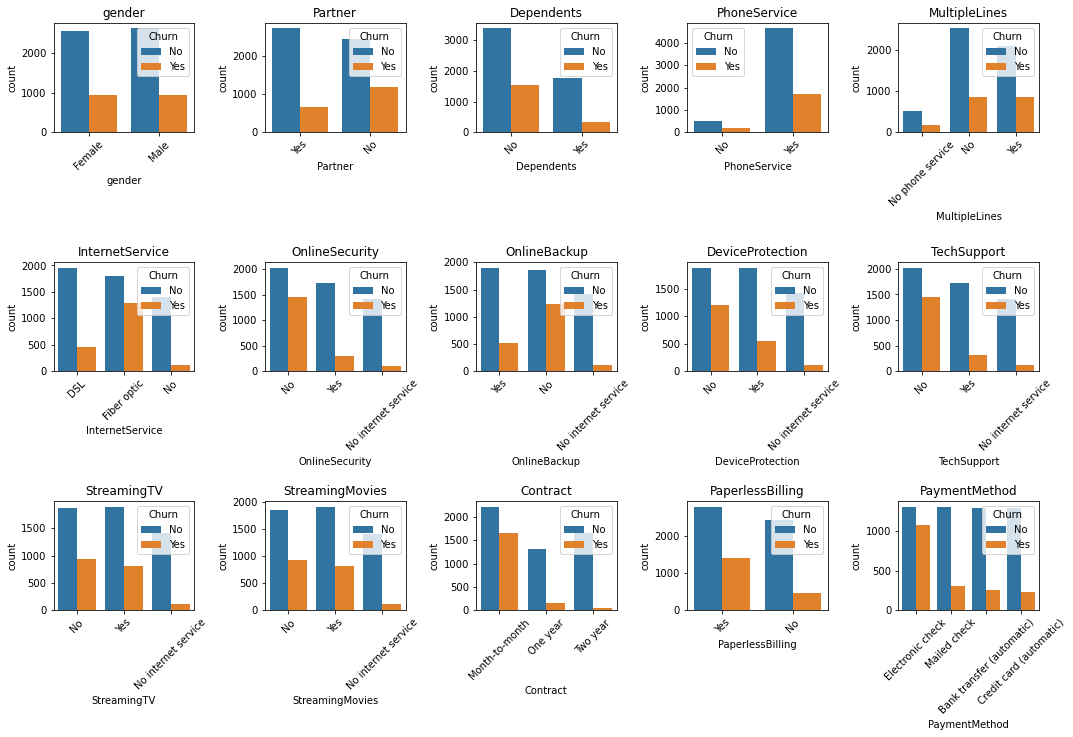

In [16]:
# Stacked Bar Plot with Target Variable
# Shows how each category relates to the target variable, such as the proportion of churned vs. non-churned customers within each category.
plt.figure(figsize=(15, 12))
for i, column in enumerate(cat_cols, 1):
    plt.subplot(4, 5, i)  # Adjust subplot layout as per number of features
    sns.countplot(data=df, x=column, hue='Churn')
    plt.title(column) # print feature name along with the percantage of missing values in the feature
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

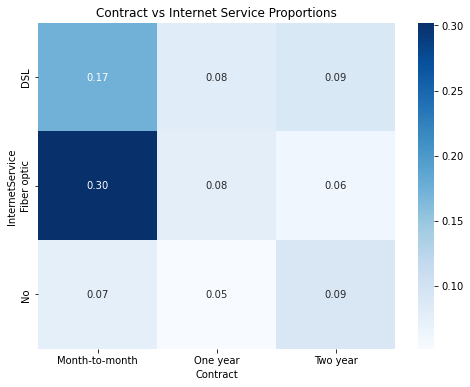

In [17]:
# Heatmap of Categorical Features with Target
# Shows correlations between multiple categorical features and the target.

# Create a crosstab to visualize the relationship between 'Contract' and 'InternetService' with 'Churn'
heatmap_df = pd.crosstab(df['InternetService'], df['Contract'], normalize=True)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.title('Contract vs Internet Service Proportions')
plt.show()

## Encoding Categorical Features

For columns with two categories we will use label encoding (e.g., 0 for Male, 1 for Female).\
For columns with more than two categories, we will use one-hot encoding.\
For columns with high cardinality, we will use Binary Encoding.

In [18]:
df[cat_cols].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

Features for 2 unique values we will use label encoding and for others one-hot encoding.

In [19]:
# high cardinality, nominal and binary variables in the datasets
binary_cat = [] # define binary categories in a list for applying label encoding
nominal_cat = [] # define nominal categories in a list for applying one-hot encoding

for col in cat_cols:
    unique_values = df[col].nunique()

    # Decide on encoding based on number of unique values and type
    if unique_values == 2:
        binary_cat.append(col)
    else:
        nominal_cat.append(col)

In [20]:
print(binary_cat)
print(nominal_cat)

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


### Perform Pipeline

Label Encoding: Converts binary categorical columns (Yes/No, Male/Female) to 0 and 1 values.\
One-Hot Encoding for Multi-Class Categorical Features: Converts categorical columns with multiple categories into binary dummy variables.

In [21]:
# Binary categorical transformer using LabelEncoder
'''Since LabelEncoder doesn’t support ColumnTransformer directly,
we’ll wrap it in a FunctionTransformer to apply it only to the binary categorical columns.'''
def label_encode_binary(df):
    le = LabelEncoder()
    return df.apply(lambda x: le.fit_transform(x))

# Binary-class categorical transformer
binary_transformer = Pipeline(steps=[
    ('label_encoder', FunctionTransformer(label_encode_binary))
])

# Multi-class categorical transformer: One-Hot Encoding
nominal_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(drop='first')) # handle_unknown='ignore'
])

## Combine transformers in a ColumnTransformer

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_col_no_skewed', num_transformer, num_col_no_skewed), # # Numerical features for no skewed values
        ('num_col_skewed', num_transformer_skewed, num_col_skewed), # Numerical features for skewed values
        ('binary_encoding', binary_transformer, binary_cat), # LabelEncoder for binary categorical features
        ('nominal_encoding', nominal_transformer, nominal_cat) # OneHotEncoder for nominal categorical features
    ],
    remainder='passthrough'  # Keep the other columns (if any) as is
)

## Splitting the Dataset and Handling imbalanced data (Resampling methods+Class Weight)

### Handling Imbalance data
Handling imbalanced data is indeed a crucial step in classification tasks like churn prediction, where one class (e.g., customers who churn) may be significantly smaller than the other.

We use following techniques to deal with that:\
1. Resampling Techniques (SMOTE)
2. Using Class Weights

SMOTE is applied after preprocessing but before model training, creating a balanced training set.

In models like logistic regression, decision trees, SVM and random forests, we set set class_weight='balanced', which assigns weights inversely proportional to class frequencies. This ensures the model to handle the imbalance by giving more weight to the minority class..

In [23]:
# Separate target and features
X = df.drop("Churn", axis=1)

# Encode the target column separately
# Convert target to binary values
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

## Training, Testing, Evaluation

In [24]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

In [25]:
# predicting, testing and evaluation
for model_name, model in models.items():

    # Train the model (fit the entire pipeline)
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions using the final estimator on the transformed test data
    y_pred = model.predict(X_test_preprocessed)

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1036
           1       0.52      0.82      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1036
           1       0.50      0.55      0.53       373

    accuracy                           0.74      1409
   macro avg       0.67      0.68      0.67      1409
weighted avg       0.74      0.74      0.74      1409

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1036
           1       0.62      0.57      0.59       373

    accuracy                           0.79      1409
   macro av

1. Logistic Regression:\
Accuracy: 75%\
Strength: High recall for class 1 (82%), meaning it captures most positives.\
Weakness: Low precision for class 1 (52%), leading to false positives.\
Best for: Detecting positives but may misclassify negatives.

2. Decision Tree:\
Accuracy: 74%\
Strength: Balanced performance for class 0.\
Weakness: Struggles with class 1 (low precision: 50%, recall: 55%).\
Best for: Simple, interpretable model but not ideal for imbalanced data.

3. Random Forest:\
Accuracy: 79%\
Strength: Strong precision and recall for class 0 (both ~85%). Improved handling of class 1.\
Weakness: Moderate performance for class 1 (precision: 62%, recall: 57%).\
Best for: Overall balanced and reliable; handles imbalance better than simpler models.

4. XGBoost:\
Accuracy: 79%\
Strength: Consistent high performance for class 0. Balanced precision and recall for class 1.\
Weakness: Moderate recall for class 1 (59%).\
Best for: Similar to Random Forest; excellent overall performance.

5. SVM (Support Vector Machine):\
Accuracy: 77%\
Strength: High recall for class 1 (80%). Good at detecting positives.\
Weakness: Low precision for class 1 (55%), causing false positives.\
Best for: Reducing false negatives but not false positives.

6. KNN (K-Nearest Neighbors):\
Accuracy: 70%\
Strength: Good precision for class 0 (88%).\
Weakness: Poor class 1 precision (46%). Struggles with imbalanced data.\
Best for: Simpler datasets; not ideal here.

7. Naive Bayes:\
Accuracy: 67%\
Strength: High recall for class 1 (90%), best at capturing true positives.\
Weakness: Very low precision for class 1 (44%), leading to many false positives.\
Best for: Prioritizing recall over precision; not recommended for balanced results.

Top Picks:\
Best Balanced Performance: Random Forest or XGBoost.\
If Recall for Class 1 is Critical: Naive Bayes or Logistic Regression (with tuning to improve precision).

### Ensemble Methods
Ensembles can increase performance by leveraging different strengths of models, especially when combined with balanced resampling.

We perform here 2 types of ensembles.
1. Voting Classifier:
    The Voting Classifier aggregates the predictions of multiple models by voting. There are two main types:
    
    Hard Voting: Each model makes a class prediction (0 or 1), and the final prediction is the class that gets the majority vote.\
    Soft Voting: Each model outputs a probability for each class, and the final prediction is the class with the highest average probability across models.
    
   Use Case:\
    Simple and quick to implement.\
    Effective when to combine the strengths of multiple models without additional complexity.


2. Stacking Classifier:
    Stacking combines multiple base models and feeds their predictions into a meta-model (also known as a second-level model).\
    The meta-model learns how to best combine the outputs of the base models to improve overall performance.
    
    More powerful and flexible than voting but also more complex.\
    Best used when to exploit the specific strengths of different models and combine them in a learned way to enhance predictive performance.

In [26]:
# Voting Classifier (for both soft and hard voting)
for votes in ["soft", "hard"]:
    voting_clf = VotingClassifier(
        estimators=list(models.items()),
        voting=votes
    )
    voting_clf.fit(X_train_resampled, y_train_resampled)
    y_pred_voting = voting_clf.predict(X_test_preprocessed)

    print(f"Voting Classifier Classification Report ({votes}):")
    print(classification_report(y_test, y_pred_voting))

Voting Classifier Classification Report (soft):
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1036
           1       0.56      0.75      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409

Voting Classifier Classification Report (hard):
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1036
           1       0.57      0.75      0.65       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



Evaluation and Insights:

1. Voting Classifier (Soft Voting):\
Accuracy: 78%\
Class 0: High precision (0.90) and good recall (0.79).\
Class 1: Moderate precision (0.56) but strong recall (0.75).\
F1-Score: Balanced performance (0.64 for class 1).\
Best for: Situations where capturing true positives is important, as the recall for class 1 is high.


2. Voting Classifier (Hard Voting):\
Accuracy: 78%\
Class 0: Similar to soft voting, with high precision (0.90) and good recall (0.79).\
Class 1: Slightly better precision (0.57) and the same recall (0.75).\
F1-Score: Similar overall to soft voting (0.65 for class 1).\
Best for: Robust performance with slightly improved precision for class 1 over soft voting.

In [27]:
# Stacking Classifier
# we predict here for all model one by one as meta model
for k in models.keys():
    stacking_clf = StackingClassifier(
        estimators=list(models.items()),
        final_estimator=models[k],
        cv=5
    )

    stacking_clf.fit(X_train_resampled, y_train_resampled)
    y_pred_stacking = stacking_clf.predict(X_test_preprocessed)

    print(f"Stacking Classifier Classification Report ({k}):")
    print(classification_report(y_test, y_pred_stacking))

Stacking Classifier Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1036
           1       0.60      0.53      0.56       373

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409

Stacking Classifier Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1036
           1       0.52      0.46      0.49       373

    accuracy                           0.75      1409
   macro avg       0.67      0.65      0.66      1409
weighted avg       0.74      0.75      0.74      1409

Stacking Classifier Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.51      0.56       373


Evaluation and Insights:

1. Logistic Regression (Stacking Meta-model):\
Accuracy: 78%\
Class 0: Strong performance (precision: 0.84, recall: 0.87).\
Class 1: Moderate precision (0.60), lower recall (0.53).\
F1-Score: Balanced for class 0 but weaker for class 1.\
Best for: Good overall performance, but weaker at capturing all positives (class 1).

2. Decision Tree (Base Model):\
Accuracy: 75%\
Class 0: Good recall (0.85) and precision (0.81).\
Class 1: Lower precision (0.52) and recall (0.46).\
F1-Score: Low for class 1, indicating struggles with minority class.\
Best for: Basic baseline but not suitable for imbalanced data.

3. Random Forest (Base Model):\
Accuracy: 79%\
Class 0: High precision (0.83), strong recall (0.89).\
Class 1: Improved precision (0.63) but recall (0.51) is moderate.\
F1-Score: Better handling of class 1 than simpler models.\
Best for: Balanced performance and good for imbalanced data.

4. XGBoost (Base Model):\
Accuracy: 78%\\\
Class 0: Similar to Random Forest (precision: 0.83, recall: 0.89).\\
Class 1: Moderate precision (0.62) and recall (0.49).\
F1-Score: Comparable to Random Forest but slightly weaker recall.\
Best for: Robust and reliable overall performance.
\
5. Support Vector Machine (SVM, Base Model):\
Accuracy: 79%\\\
Class 0: High precision (0.84) and recall (0.88).\\
Class 1: Precision (0.62) and recall (0.52) are balanced but moderate.\
F1-Score: Similar to XGBoost.\
Best for: Good for handling overall accuracy but not the best at detecting positives.

6. KNN (Base Model):\
Accuracy: 79%\\
Class 0: Strong precision (0.83) and recall (0.88).\
Class 1: Precision (0.61), lower recall (0.51).\
F1-Score: Moderate overall.\
Best for: Simple structure; reliable for class 0 but struggles with class 1.

7. Naive Bayes (Base Model):\
Accuracy: 79%\
Class 0: High precision (0.88) but slightly lower recall (0.83).\
Class 1: Improved recall (0.70) and precision (0.59).\
F1-Score: Better recall than other models for class 1.\
Best for: Prioritizing recall in class 1.


Top Performers: Random Forest, XGBoost, and SVM consistently achieve high accuracy and good class 0 performance.\
For Class 1 Detection: Naive Bayes shows the best recall for capturing positives.\
Meta-model: Using Logistic Regression in the stacking classifier provides balanced overall performance.

### Neural Network

In [28]:
# Define a neural network model
# L2 regularization to penalize large weights
nn_model = Sequential([
    Input(shape=(X_train_preprocessed.shape[1],)),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

In [29]:
# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',     # Monitor validation loss
                              patience=5,            # Stop after 5 epochs with no improvement
                              restore_best_weights=True)  # Restore the best weights

# learning rate scheduler to adjust the learning rate dynamically during training
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [31]:
hist = nn_model.fit(X_train_preprocessed, y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.2, # validation_data=(X_test_preprocessed, y_test)
          callbacks=[early_stopping]) #, reduce_lr

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5947 - loss: 1.6729 - val_accuracy: 0.7888 - val_loss: 1.4307
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7090 - loss: 1.3818 - val_accuracy: 0.7995 - val_loss: 1.2303
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 1.1714 - val_accuracy: 0.8030 - val_loss: 1.0675
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 1.0410 - val_accuracy: 0.8048 - val_loss: 0.9378
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.9386 - val_accuracy: 0.8083 - val_loss: 0.8361
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7904 - loss: 0.8084 - val_accuracy: 0.8075 - val_loss: 0.7577
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7922 - loss: 0.7550 - val_accuracy: 0.8066 - val_loss: 0.6885
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7909 - loss: 0.6929 - val_accuracy: 0.8083 - v

### Evaluate the Model

In [32]:
# Predict on the test set
y_pred = (nn_model.predict(X_test_preprocessed) > 0.5).astype("int")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1036
           1       0.66      0.62      0.64       373

    accuracy                           0.81      1409
   macro avg       0.76      0.75      0.76      1409
weighted avg       0.81      0.81      0.81      1409

Accuracy: 81.48%


Evaluation and Insights:

Class-wise Breakdown:

Class 0 (Non-Churn/Negative Class):\
Precision: 0.87 (Very good; low false positives)\
Recall: 0.89 (Excellent; captures most true negatives)\
F1-Score: 0.88 (Balanced high precision and recall)

Strength: The model performs exceptionally well for class 0, accurately identifying non-churn customers.

Class 1 (Churn/Positive Class):\
Precision: 0.66 (Decent; some false positives)\
Recall: 0.62 (Moderate; misses some actual churn cases)\
F1-Score: 0.64 (Balanced but lower than class 0)\

Weakness: The model's performance for class 1 (churn) is moderate. It correctly identifies 62% of churn cases but may miss others.

Macro and Weighted Averages:

Macro Avg F1-Score: 0.76\
Indicates balanced performance across both classes.\
Weighted Avg F1-Score: 0.81\
Reflects overall accuracy, weighted by class distribution.

### Plotting Accuracy and Loss function

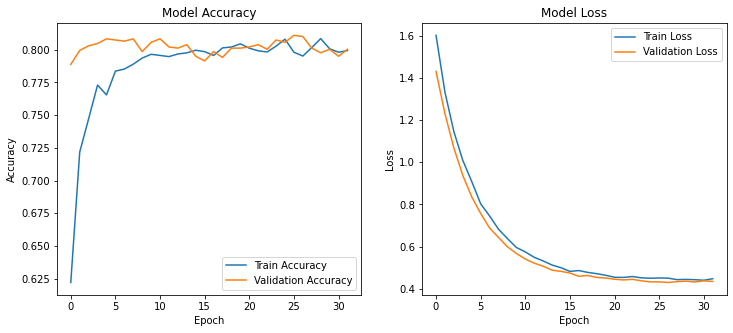

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Analysis of the Updated Learning Curves:

1. Accuracy Plot:

Training Accuracy Increases: The training accuracy improves consistently, indicating that the model is learning patterns from the training data.\
Validation Accuracy Plateaus: The validation accuracy increases quickly and then plateaus around 80%, suggesting the model is reaching its performance limit.\
Good Generalization: Since the training and validation accuracy curves are close together and have similar trends, the model does not appear to be overfitting significantly.

2. Loss Plot:

Decreasing Loss: Both the training and validation loss decrease over time, indicating that the model is learning and minimizing the error.\
Similar Loss Curves: The training and validation loss curves are close together, suggesting that the model is not overfitting. If the validation loss was much higher than the training loss, it would indicate overfitting.

### Plot Precision, Recall, and F1 Score Curves

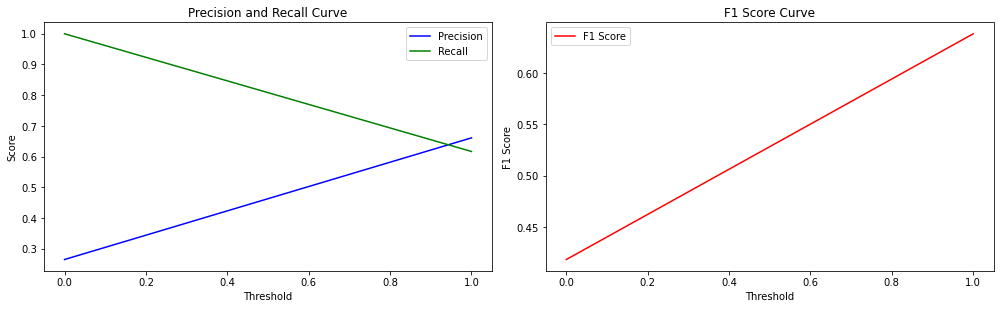

In [34]:
# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Plot Precision-Recall curve and F1 Score curve
plt.figure(figsize=(14, 8))

# Plot Precision and Recall curve
plt.subplot(2, 2, 1)
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="green")
plt.title("Precision and Recall Curve")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")

# Plot F1 Score curve
plt.subplot(2, 2, 2)
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="red")
plt.title("F1 Score Curve")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

1. Precision and Recall Curve:\
Blue Line (Precision): Precision decreases as the threshold increases.\
Green Line (Recall): Recall decreases as the threshold increases.\
Threshold Effect:\
Low Thresholds: At lower thresholds (close to 0), recall is high (close to 1), but precision is low. This means the model predicts more positive samples but at the cost of many false positives.\
High Thresholds: At higher thresholds (close to 1), precision is high but recall is low. The model becomes more conservative, predicting fewer positives, but those predictions are more likely to be correct.
Trade-off:\
There is always a trade-off between precision and recall. Increasing precision often decreases recall and vice versa.
The point where the precision and recall curves intersect could represent a balanced threshold, depending on the application's needs.

2. F1 Score Curve:\
Red Line (F1 Score): The F1 score increases linearly with the threshold in this plot.\
F1 Score Behavior:\
The F1 score represents the harmonic mean of precision and recall, balancing the two metrics.
Typically, the F1 score should peak at an optimal threshold, but in this plot, it increases steadily, suggesting that the model might need fine-tuning in threshold selection.

In [35]:
# we can calculate now the optimal threshold from f1-score

optimal_idx = np.argmax(f1_scores)  # Index of the max F1 score
optimal_threshold = thresholds[optimal_idx]

# Print the optimal threshold
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum F1 Score: {f1_scores[optimal_idx]:.2f}")

Optimal Threshold: 1.0000
Maximum F1 Score: 0.64


### Ensemble Methods:

Combine neural networks with other classifiers.

Approach: Use Neural Network as a Feature Extractor

1. Neural Network extracts high-level features from the data.
2. Other classifiers uses these features for final prediction.

Steps:
1. Train the Neural Network: Train the NN to learn important representations of the data. (It is already done)
2. Extract Features: Use the outputs from a hidden layer as new features.
3. Train other classifiers: Use these extracted features as inputs to train other classifiers.
4. Evaluation.

In [36]:
# Extract Features from hidden layers
ext_features = Sequential(nn_model.layers[:-1]) # Remove the output layer
X_train_ext_features = ext_features.predict(X_train_preprocessed)
X_test_ext_features = ext_features.predict(X_test_preprocessed)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
# predicting, testing and evaluation
for model_name, mod in models.items():

    # Train the model (fit the entire pipeline)
    mod.fit(X_train_ext_features, y_train)

    # Make predictions using the final estimator on the transformed test data
    y_pred_ext_features = mod.predict(X_test_ext_features)

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred_ext_features))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1036
           1       0.53      0.81      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1036
           1       0.51      0.49      0.50       373

    accuracy                           0.74      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.66      0.53      0.59       373

    accuracy                           0.80      1409
   macro av

Evaluation and Insight:

1. Logistic Regression:\
Accuracy: 76%\
Class 0: Precision (0.92), Recall (0.74), F1 (0.82)\
Class 1: Precision (0.53), Recall (0.81), F1 (0.64)\
Strengths: Excellent precision for class 0, high recall for class 1.\
Weaknesses: Struggles with false positives for class 1.\
Best for: Balanced handling of imbalanced data with a focus on capturing positives.

2. Decision Tree:\
Accuracy: 74%\
Class 0: Precision (0.82), Recall (0.83), F1 (0.82)\
Class 1: Precision (0.51), Recall (0.49), F1 (0.50\
Strengths: Consistent performance for class 0.\
Weaknesses: Weak recall and precision for class 1.\
Best for: Basic feature extraction check, but not ideal for imbalanced datasets.

3. Random Forest:\
Accuracy: 80%\
Class 0: Precision (0.84), Recall (0.90), F1 (0.87)\
Class 1: Precision (0.66), Recall (0.53), F1 (0.59)\
Strengths: High accuracy; strong precision and recall for class 0.\
Weaknesses: Moderate recall for class 1.\
Best for: Reliable overall performance; robust feature handling.

4. XGBoost:\
Accuracy: 80%\
Class 0: Precision (0.85), Recall (0.88), F1 (0.86)\
Class 1: Precision (0.63), Recall (0.56), F1 (0.59)\
Strengths: Consistent high accuracy; good handling of class 0.\
Weaknesses: Struggles slightly with class 1 recall.\
Best for: Optimized performance on complex data; requires tuning for minority class.

5. Support Vector Machine (SVM):\
Accuracy: 76%\
Class 0: Precision (0.92), Recall (0.74), F1 (0.82)\
Class 1: Precision (0.53), Recall (0.81), F1 (0.64)\
Strengths: High precision and recall balance.\
Weaknesses: Class 1 recall and precision slightly inconsistent.\
Best for: Consistent with Logistic Regression; good for linearly separable features.

6. K-Nearest Neighbors (KNN):\
Accuracy: 78%\
Class 0: Precision (0.85), Recall (0.86), F1 (0.85)\
Class 1: Precision (0.59), Recall (0.58), F1 (0.59)\
Strengths: Balanced performance across classes.\
Weaknesses: Sensitive to class imbalance; relies on distance metrics.\
Best for: Simplified models; works well with high-dimensional features.

7. Naive Bayes:\
Accuracy: 71%\
Class 0: Precision (0.94), Recall (0.65), F1 (0.77)\
Class 1: Precision (0.48), Recall (0.89), F1 (0.62)\
Strengths: High recall for class 1 (best among all models).\
Weaknesses: High false positives for class 0.\
Best for: Prioritizing minority class recall; suitable when capturing all positives is crucial.

Top Performers: Random Forest and XGBoost provide the highest accuracy with robust handling of extracted features.\
Class 1 Focus: Naive Bayes excels in capturing positive cases (high recall).\
Balanced Choice: Logistic Regression and SVM maintain a good balance between precision and recall.

### Stacking Ensemble

In [38]:
for k in models.keys():
    # Train Base Models and Combine their Predictions with NN Predictions
    stacking_clf_nn = StackingClassifier(
                estimators=list(models.items()),
                final_estimator=models[k],
                cv=5
    )

    # Fit Base Classifiers and Meta-Classifier with resampled datasets
    stacking_clf_nn.fit(X_train_resampled, y_train_resampled)

    # Get Base Model Predictions for Meta-Classifier for orginal preprocessed datasets
    y_train_pred_stacking_nn = stacking_clf_nn.predict(X_train_preprocessed)
    y_test_pred_stacking_nn = stacking_clf_nn.predict(X_test_preprocessed)

    # Combine Base and NN Predictions for Meta-Training
    stacked_train_preds = np.column_stack((y_train_pred_stacking_nn, X_train_ext_features))
    stacked_test_preds = np.column_stack((y_test_pred_stacking_nn, X_test_ext_features))

    # Train Final Meta-Classifier on Combined Predictions
    meta_model = models[k]
    meta_model.fit(stacked_train_preds, y_train)

    # Final Prediction on Test Data
    final_preds = meta_model.predict(stacked_test_preds)

    # Evaluate the Model
    print(f"Stacking Classifier Classification Report ({k}):")
    print(classification_report(y_test, final_preds))

Stacking Classifier Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1036
           1       0.60      0.53      0.56       373

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409

Stacking Classifier Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1036
           1       0.53      0.49      0.51       373

    accuracy                           0.75      1409
   macro avg       0.67      0.67      0.67      1409
weighted avg       0.74      0.75      0.75      1409

Stacking Classifier Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.50      0.55       373


Evaluation and Insight:

1. Logistic Regression (Stacked):\
Accuracy: 78%\
Class 0: Precision (0.84), Recall (0.87), F1 (0.86)\
Class 1: Precision (0.60), Recall (0.53), F1 (0.56)\
Strengths: Strong recall for class 0.\
Weaknesses: Recall and precision for class 1 could be better.\
Best for: Balanced accuracy with consistent performance for class 0.

2. Decision Tree (Stacked):
Accuracy: 75%\
Class 0: Precision (0.82), Recall (0.84), F1 (0.83)\
Class 1: Precision (0.53), Recall (0.49), F1 (0.51)\
Strengths: Consistent precision and recall for class 0.\
Weaknesses: Struggles with class 1 detection.\
Best for: Simple, interpretable models but limited class 1 handling.

3. Random Forest (Stacked):\
Accuracy: 79%\
Class 0: Precision (0.83), Recall (0.89), F1 (0.86)\
Class 1: Precision (0.63), Recall (0.50), F1 (0.55)\
Strengths: Strong class 0 performance.\
Weaknesses: Moderate class 1 recall.\
Best for: Reliable overall performance; works well for large feature sets.

4. XGBoost (Stacked):\
Accuracy: 79%\
Class 0: Precision (0.83), Recall (0.89), F1 (0.86)\
Class 1: Precision (0.62), Recall (0.50), F1 (0.55)\
Strengths: Consistent accuracy and good feature learning.\
Weaknesses: Moderate performance for minority class recall.\
Best for: Handling complex patterns; suitable for further tuning.

5. Support Vector Machine (SVM) (Stacked):\
Accuracy: 79%\
Class 0: Precision (0.84), Recall (0.88), F1 (0.86)\
Class 1: Precision (0.62), Recall (0.52), F1 (0.57)\
Strengths: Balanced accuracy; good handling of class 0.\
Weaknesses: Class 1 recall could improve.\
Best for: Consistent class separation; performs well with high-dimensional data.

6. K-Nearest Neighbors (KNN) (Stacked):\
Accuracy: 79%\
Class 0: Precision (0.83), Recall (0.89), F1 (0.86)\
Class 1: Precision (0.62), Recall (0.50), F1 (0.56)\
Strengths: Strong for majority class detection.\
Weaknesses: Sensitive to imbalanced data.\
Best for: Simple datasets with fewer features; performs well with sufficient data points.

7. Naive Bayes (Stacked):\
Accuracy: 74%\
Class 0: Precision (0.92), Recall (0.70), F1 (0.80)\
Class 1: Precision (0.50), Recall (0.84), F1 (0.63)\
Strengths: High recall for class 1.\
Weaknesses: Lower precision for class 1; prone to false positives.\
Best for: Prioritizing recall for minority class; good for highly imbalanced data.

Top Performers: XGBoost and Random Forest deliver the best accuracy (79%) and class 0 performance.\
Balanced Class Handling: SVM and Logistic Regression perform well across classes, especially with precision and recall balance.\
Minority Class Focus: Naive Bayes captures class 1 well with high recall, valuable when false negatives are costly.

### Best Model Evaluation

Till now, based on the detailed classification reports and metrics:\
Best Overall: Neural Network model, because of it's highest accuracy and balanced class performance.

### Hyperparameter Tuning of the Neural Network

We use here Keras Tuner (Random Search or Hyperband).

In [40]:
def build_model(hp):
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=(X_train_preprocessed.shape[1],)))

    # First Hidden Layer
    model.add(Dense(
        units=hp.Choice('layer1', values=[16, 32, 64, 128]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_layer1', values=[0.1, 0.01, 0.001, 0.0001]))
    ))
    
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second Hidden Layer
    model.add(Dense(
        units=hp.Choice('layer2', values=[16, 32, 64, 128]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_layer2', values=[0.1, 0.01, 0.001, 0.0001]))
    ))

    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))

    # Third Hidden Layer
    model.add(Dense(
        units=hp.Choice('layer3', values=[16, 32, 64, 128]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_layer3', values=[0.1, 0.01, 0.001, 0.0001]))
    ))
    
    model.add(Dropout(hp.Float('dropout3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [41]:
# Initialize the Keras Tuner (Random Search or Hyperband)
"""
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of models to try
    executions_per_trial=2,  # Average results over multiple runs
    directory='nn_hyperparameters_rs',
    project_name='Telco_customer_churm'
)"""
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='nn_hyperparameters_hb',
    project_name='Telco_customer_churm'
)

In [42]:
# Search for the best hyperparameters
tuner.search(X_train_preprocessed, y_train, epochs=100, validation_split=0.2, batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[16, 32, 64]), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
Optimal Hyperparameters:
- Units in Layer 1: {best_hps.get('layer1')}
- L2 Regularization in Layer 1: {best_hps.get('l2_layer1')}
- Dropout in Layer 1: {best_hps.get('dropout1')}
- Units in Layer 2: {best_hps.get('layer2')}
- L2 Regularization in Layer 2: {best_hps.get('l2_layer2')}
- Dropout in Layer 2: {best_hps.get('dropout2')}
- Units in Layer 3: {best_hps.get('layer3')}
- L2 Regularization in Layer 3: {best_hps.get('l2_layer3')}
- Dropout in Layer 3: {best_hps.get('dropout3')}
- Learning Rate: {best_hps.get('learning_rate')}
- Batch Size: {best_hps.get('batch_size')}
""")

Trial 90 Complete [00h 00m 08s]
val_accuracy: 0.7994676232337952

Best val_accuracy So Far: 0.8145518898963928
Total elapsed time: 00h 10m 58s

Optimal Hyperparameters:
- Units in Layer 1: 32
- L2 Regularization in Layer 1: 0.001
- Dropout in Layer 1: 0.2
- Units in Layer 2: 64
- L2 Regularization in Layer 2: 0.0001
- Dropout in Layer 2: 0.30000000000000004
- Units in Layer 3: 16
- L2 Regularization in Layer 3: 0.0001
- Dropout in Layer 3: 0.5
- Learning Rate: 0.001
- Batch Size: 32



In [43]:
# Train the best model on the full training data
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_preprocessed, y_train, epochs=100, validation_split=0.2, batch_size=int(best_hps.get('batch_size')), callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7122 - loss: 0.6324 - val_accuracy: 0.7986 - val_loss: 0.4591
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.5237 - val_accuracy: 0.7986 - val_loss: 0.4495
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7738 - loss: 0.4973 - val_accuracy: 0.8066 - val_loss: 0.4417
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7719 - loss: 0.4853 - val_accuracy: 0.8083 - val_loss: 0.4376
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7725 - loss: 0.4891 - val_accuracy: 0.8048 - val_loss: 0.4333
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8053 - loss: 0.4540
Test Accuracy: 80.48%
